# ResNet 기반 주조 제품 정상/불량 분류 및 Grad-CAM 시각화

이 노트북에서는 주조 제품 이미지를 이용해 ResNet 기반 CNN으로 정상/불량을 분류하고, Grad-CAM을 통해 모델의 판단 근거를 시각화합니다. 마지막으로 학습된 모델을 저장합니다.

In [104]:
# sample_dir가 정의되어 있지 않으면 아래 라인을 먼저 실행
sample_dir = '../data/casting_data_sample' # 변수를 설정하거나 값을 할당

In [105]:
import os # 파일 시스템 관리 및 경로 조작을 위한 라이브러리
# (sample_dir가 정의되어 있어야함)

In [106]:
# 샘플 데이터 개수 확인
for split in ['train', 'test']: 
    for cls in ['ok_front', 'def_front']:
        dir_path = os.path.join(sample_dir, f'{split}/{cls}') # 변수를 설정하거나 값을 할당
        if os.path.exists(dir_path): # 파일 시스템 관련 작업을 수행
            n_files = len([f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]) 
            print(f"{split}/{cls}: {n_files}장")
        else: # 
            print(f"{split}/{cls}: 폴더 없음")

train/ok_front: 358장
train/def_front: 337장
test/ok_front: 213장
test/def_front: 209장


In [107]:
import os
import shutil
import random

# 1. 경로 설정
base_dir = '../data/casting_data'      # 원본 데이터
sample_dir = '../data/casting_data_sample' # 샘플 데이터 저장할 곳

# 2. 기존 폴더가 있다면 싹 지워서 초기화 (가장 중요!)
if os.path.exists(sample_dir):
    shutil.rmtree(sample_dir)
os.makedirs(sample_dir)

def sample_images(src_dir, dst_dir, n=200):
    os.makedirs(dst_dir, exist_ok=True)
    files = [f for f in os.listdir(src_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # 3. 정확히 n장(200장)만 랜덤으로 추출
    sampled = random.sample(files, min(n, len(files))) 
    for f in sampled: 
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_dir, f))

# 4. 각 폴더별로 정확히 200장씩만 복사 (총 800장 세팅)
sample_images(os.path.join(base_dir, 'train/ok_front'), os.path.join(sample_dir, 'train/ok_front'), n=200) 
sample_images(os.path.join(base_dir, 'train/def_front'), os.path.join(sample_dir, 'train/def_front'), n=200) 
sample_images(os.path.join(base_dir, 'test/ok_front'), os.path.join(sample_dir, 'test/ok_front'), n=200)
sample_images(os.path.join(base_dir, 'test/def_front'), os.path.join(sample_dir, 'test/def_front'), n=200) 

print("✅ 모든 폴더에 데이터가 200장씩 깔끔하게 정리되었습니다!")

✅ 모든 폴더에 데이터가 200장씩 깔끔하게 정리되었습니다!


## 1. 필요한 라이브러리 임포트

In [108]:
import os # 파일 시스템 관리 및 경로 조작을 위한 라이브러리
import numpy as np # 수치 계산 및 행렬 연산을 위한 데이터 처리 라이브러리
import pandas as pd # 데이터프레임 관리 및 데이터 분석용 라이브러리
import matplotlib.pyplot as plt # 학습 결과 및 이미지 시각화용 라이브러리
from PIL import Image # 이미지 파일 로드 및 기본 전처리 라이브러리
from tqdm import tqdm # 반복문 진행 상태를 바(bar)로 표시해주는 라이브러리

import torch # GPU 가속 및 텐서 연산을 지원하는 PyTorch 메인 라이브러리
import torch.nn as nn # 신경망 구성 요소(레이어, 손실 함수 등)를 제공하는 모듈
import torch.optim as optim # 모델 최적화 알고리즘(가중치 수정) 제공 모듈
from torch.utils.data import Dataset, DataLoader # 학습 데이터를 미니 배치 단위로 로드하는 모듈
from torchvision import transforms, models # 이미지 변환 도구 및 사전 학습된 모델 제공 라이브러리
from sklearn.model_selection import train_test_split # 데이터셋을 학습/검증/테스트용으로 분할하는 함수
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # 모델의 예측 성능 및 정확도 지표 측정 도구

from pytorch_grad_cam import GradCAM # 모델의 판단 근거 시각화(Grad-CAM)용 라이브러리
import cv2 # OpenCV: 이미지 합성 및 고급 영상 처리 라이브러리
import pickle # 선택된 데이터나 객체를 파일로 저장/복원하는 라이브러리

In [109]:
# 데이터 경로 설정
import os # 파일 시스템 관리 및 경로 조작을 위한 라이브러리

data_dir = '../data/casting_data_sample/'
train_ok_dir = os.path.join(data_dir, 'train/ok_front') 
train_def_dir = os.path.join(data_dir, 'train/def_front')
test_ok_dir = os.path.join(data_dir, 'test/ok_front') 
test_def_dir = os.path.join(data_dir, 'test/def_front') 

# 이미지 경로와 라벨 리스트 생성 (확장자 다양하게 허용)
def get_image_paths_and_labels(dir_ok, dir_def): 
    ok_imgs = [(os.path.join(dir_ok, f), 0) for f in os.listdir(dir_ok) if f.lower().endswith(('.jpg', '.jpeg', '.png'))] 
    def_imgs = [(os.path.join(dir_def, f), 1) for f in os.listdir(dir_def) if f.lower().endswith(('.jpg', '.jpeg', '.png'))] 
    return ok_imgs + def_imgs 

train_data = get_image_paths_and_labels(train_ok_dir, train_def_dir) 
test_data = get_image_paths_and_labels(test_ok_dir, test_def_dir) 

# 데이터프레임 생성
df_train = pd.DataFrame(train_data, columns=['img_path', 'label']) 
df_test = pd.DataFrame(test_data, columns=['img_path', 'label']) 

# 데이터 분포 및 파일 개수 확인
print('ok_front(train):', len(os.listdir(train_ok_dir)))
print('def_front(train):', len(os.listdir(train_def_dir))) 
print('ok_front(test):', len(os.listdir(test_ok_dir)))
print('def_front(test):', len(os.listdir(test_def_dir))) 
print('df_train shape:', df_train.shape)
print('df_test shape:', df_test.shape)
print(df_train.head()) 
print('Train label count:', df_train['label'].value_counts()) 
print('Test label count:', df_test['label'].value_counts()) 

ok_front(train): 200
def_front(train): 200
ok_front(test): 200
def_front(test): 200
df_train shape: (400, 2)
df_test shape: (400, 2)
                                            img_path  label
0  ../data/casting_data_sample/train/ok_front\cas...      0
1  ../data/casting_data_sample/train/ok_front\cas...      0
2  ../data/casting_data_sample/train/ok_front\cas...      0
3  ../data/casting_data_sample/train/ok_front\cas...      0
4  ../data/casting_data_sample/train/ok_front\cas...      0
Train label count: label
0    200
1    200
Name: count, dtype: int64
Test label count: label
0    200
1    200
Name: count, dtype: int64


## 2. 데이터셋 불러오기 및 전처리

In [110]:
# 전체 데이터를 Train 70% / Validation 15% / Test 15%로 최적 분할
from sklearn.model_selection import train_test_split # 데이터셋을 학습/검증/테스트용으로 분할하는 함수

# 기존 df_train과 df_test를 합쳐서 전체 데이터로 사용
all_df = pd.concat([df_train, df_test], ignore_index=True)

# 1단계: Train 70% 분리 (나머지 30%는 Val+Test)
train_df, temp_df = train_test_split(all_df, test_size=0.30, stratify=all_df['label'], random_state=42)

# 2단계: 나머지 30%를 Val 50% / Test 50%로 분할 (전체 기준 각 15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print('=== 최적화된 데이터 분할 (70% / 15% / 15%) ===')
print(f'Train: {len(train_df)}개 ({len(train_df)/len(all_df)*100:.1f}%)')
print(f'Validation: {len(val_df)}개 ({len(val_df)/len(all_df)*100:.1f}%)')
print(f'Test: {len(test_df)}개 ({len(test_df)/len(all_df)*100:.1f}%)')
print('\nTrain label:', train_df['label'].value_counts().to_dict())
print('Val label:', val_df['label'].value_counts().to_dict())
print('Test label:', test_df['label'].value_counts().to_dict())

=== 최적화된 데이터 분할 (70% / 15% / 15%) ===
Train: 560개 (70.0%)
Validation: 120개 (15.0%)
Test: 120개 (15.0%)

Train label: {1: 280, 0: 280}
Val label: {1: 60, 0: 60}
Test label: {1: 60, 0: 60}


In [111]:
# 변경된 변수 이름에 맞춰 상태 출력
print('=== 현재 분할된 데이터 상태 (70:15:15) ===')
print('학습 데이터(train_df) 모양:', train_df.shape)
print('검증 데이터(val_df) 모양:', val_df.shape)
print('테스트 데이터(test_df) 모양:', test_df.shape)

print('\n=== 학습 데이터 상단 5개 미리보기 ===')
print(train_df.head())

=== 현재 분할된 데이터 상태 (70:15:15) ===
학습 데이터(train_df) 모양: (560, 2)
검증 데이터(val_df) 모양: (120, 2)
테스트 데이터(test_df) 모양: (120, 2)

=== 학습 데이터 상단 5개 미리보기 ===
                                              img_path  label
207  ../data/casting_data_sample/train/def_front\ca...      1
489  ../data/casting_data_sample/test/ok_front\cast...      0
666  ../data/casting_data_sample/test/def_front\cas...      1
173  ../data/casting_data_sample/train/ok_front\cas...      0
218  ../data/casting_data_sample/train/def_front\ca...      1


In [112]:
img_size = 224 

# 학습용: 데이터 증강(Augmentation) 포함
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),      # 50% 확률로 좌우 반전
    transforms.RandomRotation(degrees=15),       # 최대 15도 회전
    transforms.ColorJitter(brightness=0.2),      # 밝기 조절
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 검증 및 테스트용: 원본 특징 유지를 위해 증강 제외
test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [113]:
class CastingDataset(Dataset): # 주조 제품 전용 데이터셋 클래스 정의
    def __init__(self, df, transform=None): 
        self.df = df.reset_index(drop=True) 
        self.transform = transform 
    def __len__(self): 
        return len(self.df)
    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'img_path'] 
        label = self.df.loc[idx, 'label'] 
        image = Image.open(img_path).convert('RGB') # 이미지 파일 읽기
        if self.transform: 
            image = self.transform(image) 
        return image, label 

# Dataset 및 DataLoader도 분할에 맞게 재정의
train_dataset = CastingDataset(train_df, transform=train_transform)
val_dataset = CastingDataset(val_df, transform=test_transform) 
test_dataset = CastingDataset(test_df, transform=test_transform) 

from torch.utils.data import DataLoader
batch_size = 32  # 커널 충돌 방지를 위해 배치 사이즈를 32로 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


# ResNet18 모델 불러오기 및 수정

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 이진 분류
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 5
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    # 검증
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

## 다양한 모델 성능 비교 실험

아래 셀에서는 ResNet18, VGG16, EfficientNet_b0 등 여러 torchvision 모델을 동일 데이터셋에서 비교합니다.

In [114]:
import torch # GPU 가속 및 텐서 연산을 지원하는 PyTorch 메인 라이브러리
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 사용 가능한 장치(GPU/CPU) 설정

In [115]:
import ssl
# SSL 인증서 확인 과정을 생략하는 설정입니다.
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
import gc # 필요한 라이브러리 임포트
import torch.nn as nn # 신경망 구성 요소(레이어, 손실 함수 등)를 제공하는 모듈
import torch.optim as optim # 모델 최적화 알고리즘(가중치 수정) 제공 모듈
from torch import nn, optim
from copy import deepcopy 

# 비교할 모델 리스트
model_names = ['resnet18', 'densenet121'] 
model_dict = { 
    'resnet18': models.resnet18, 
    'densenet121': models.densenet121 
} 

results = {} 

for name in model_names: 
    print(f'\n===== {name.upper()} 학습 시작 =====')
    
    model = model_dict[name](weights='DEFAULT') 
    
    if name == 'resnet18': 
        model.fc = nn.Sequential( 
            nn.Dropout(0.5), 
            nn.Linear(model.fc.in_features, 2) 
        ) 
    elif name == 'densenet121': 
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 2)
        )
    
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4) 
    criterion = nn.CrossEntropyLoss() 

    for epoch in range(5):
        model.train() 
        train_loss, correct, total = 0, 0, 0 
        for images, labels in train_loader: 
            images, labels = images.to(device), labels.to(device) 
            optimizer.zero_grad() 
            outputs = model(images) 
            loss = criterion(outputs, labels) 
            loss.backward() 
            optimizer.step() 
            train_loss += loss.item() * images.size(0) 
            _, predicted = outputs.max(1) 
            correct += predicted.eq(labels).sum().item() 
            total += labels.size(0) 
        train_acc = correct / total 
        print(f'Epoch {epoch+1}/5 | Train Acc: {train_acc:.4f}')

    model.eval() 
    correct, total = 0, 0 
    with torch.no_grad(): 
        for images, labels in val_loader: 
            images, labels = images.to(device), labels.to(device) 
            outputs = model(images) 
            _, predicted = outputs.max(1) 
            correct += predicted.eq(labels).sum().item() 
            total += labels.size(0) 
    val_acc = correct / total 
    print(f'{name.upper()} 검증 정확도: {val_acc:.4f}') 
    results[name] = val_acc 
    
    del model 
    torch.cuda.empty_cache() 
    gc.collect() 

import pandas as pd 
result_df = pd.DataFrame(list(results.items()), columns=['Model', 'Val Accuracy']) 
display(result_df.sort_values('Val Accuracy', ascending=False)) 


===== RESNET18 학습 시작 =====
Epoch 1/3 | Train Acc: 0.8000
Epoch 2/3 | Train Acc: 0.9589
Epoch 3/3 | Train Acc: 0.9911
Epoch 4/3 | Train Acc: 0.9911
Epoch 5/3 | Train Acc: 0.9911
RESNET18 검증 정확도: 0.9917

===== DENSENET121 학습 시작 =====
Epoch 1/3 | Train Acc: 0.7393
Epoch 2/3 | Train Acc: 0.9375


KeyboardInterrupt: 

In [ ]:
# ResNet18 모델 불러오기 및 수정

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 이진 분류
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 20 # 얼리스탑핑을 위해 에폭 상향
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

# Checkpoint 및 Early Stopping 변수 설정
best_val_loss = float('inf')
patience = 3
counter = 0
model_save_path = '../models/resnet18_best.pth'
os.makedirs('../models', exist_ok=True)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    
    # 검증
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # 체크포인트 및 얼리스탑핑 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"=> Best 모델 저장 (Val Loss: {val_loss:.4f})")
        counter = 0
    else:
        counter += 1
        print(f"=> Val Loss 지표 악화 ({counter}/{patience})")
        if counter >= patience:
            print("Learning stopped early.")
            break


c:\DLProject\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\DLProject\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 25/25 [01:16<00:00,  3.06s/it]


Epoch 1/20 | Train Loss: 0.2909 | Train Acc: 0.8643 | Val Loss: 0.0786 | Val Acc: 0.9702
=> Best 모델 저장 (Val Loss: 0.0786)


100%|██████████| 25/25 [01:16<00:00,  3.08s/it]


Epoch 2/20 | Train Loss: 0.0586 | Train Acc: 0.9744 | Val Loss: 0.0520 | Val Acc: 0.9881
=> Best 모델 저장 (Val Loss: 0.0520)


100%|██████████| 25/25 [01:17<00:00,  3.09s/it]


Epoch 3/20 | Train Loss: 0.0318 | Train Acc: 0.9898 | Val Loss: 0.0275 | Val Acc: 0.9940
=> Best 모델 저장 (Val Loss: 0.0275)


100%|██████████| 25/25 [01:15<00:00,  3.00s/it]


Epoch 4/20 | Train Loss: 0.0249 | Train Acc: 0.9910 | Val Loss: 0.0159 | Val Acc: 0.9940
=> Best 모델 저장 (Val Loss: 0.0159)


100%|██████████| 25/25 [01:15<00:00,  3.03s/it]


Epoch 5/20 | Train Loss: 0.0270 | Train Acc: 0.9923 | Val Loss: 0.0541 | Val Acc: 0.9821
=> Val Loss 지표 악화 (1/3)


100%|██████████| 25/25 [01:15<00:00,  3.02s/it]


Epoch 6/20 | Train Loss: 0.0142 | Train Acc: 0.9949 | Val Loss: 0.0977 | Val Acc: 0.9881
=> Val Loss 지표 악화 (2/3)


100%|██████████| 25/25 [01:15<00:00,  3.01s/it]


Epoch 7/20 | Train Loss: 0.0173 | Train Acc: 0.9936 | Val Loss: 0.1140 | Val Acc: 0.9821
=> Val Loss 지표 악화 (3/3)
Learning stopped early.


## 4. 학습 결과 시각화

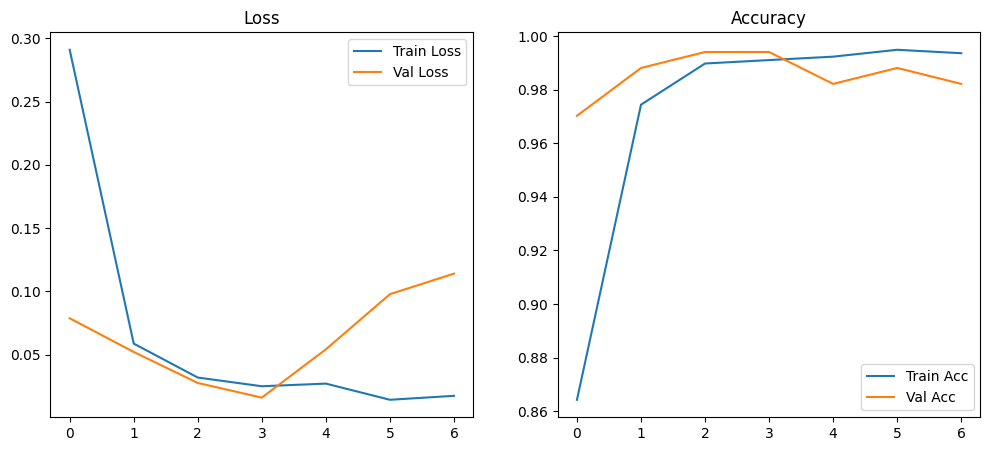

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        86
           1       1.00      0.98      0.99        82

    accuracy                           0.99       168
   macro avg       0.99      0.99      0.99       168
weighted avg       0.99      0.99      0.99       168



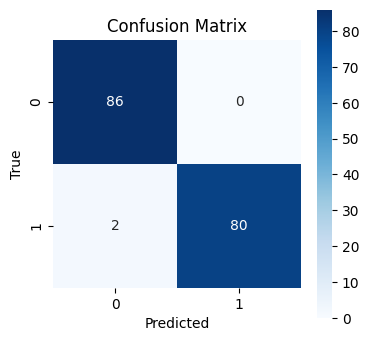

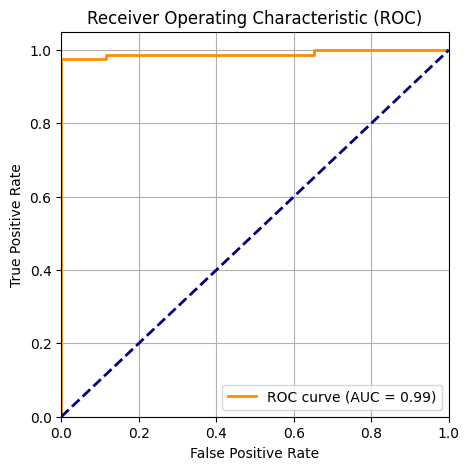

In [ ]:
import os

# 0. 저장 폴더 생성 (src/assets)
save_dir = '../src/assets'
os.makedirs(save_dir, exist_ok=True)

# 1. Loss 및 Accuracy 시각화
plt.figure(figsize=(12,5)) 
plt.subplot(1,2,1)
plt.plot(train_loss_list, label='Train Loss') 
plt.plot(val_loss_list, label='Val Loss')
plt.legend()
plt.title('Loss') 
plt.subplot(1,2,2) 
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.legend()
plt.title('Accuracy') 
plt.savefig(os.path.join(save_dir, 'learning_curves.png')) # <-- 저장 추가
plt.show() 

# 2. Confusion Matrix (수치 표시)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.eval()
y_true, y_pred, y_score = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device) 
        outputs = model(images) 
        _, predicted = torch.max(outputs, 1) 
        y_true.extend(labels.cpu().numpy()) 
        y_pred.extend(predicted.cpu().numpy()) 
        y_score.extend(torch.softmax(outputs, 1)[:,1].cpu().numpy()) 

print(classification_report(y_true, y_pred)) 
cm = confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(4,4)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True) 
plt.title('Confusion Matrix') 
plt.xlabel('Predicted') 
plt.ylabel('True') 
plt.savefig(os.path.join(save_dir, 'confusion_matrix.png')) # <-- 저장 추가
plt.show() 

# 3. ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_score) 
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,5)) 
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Receiver Operating Characteristic (ROC)') 
plt.legend(loc='lower right') 
plt.grid(True) 
plt.savefig(os.path.join(save_dir, 'roc_curve.png')) # <-- 저장 추가
plt.show()

## 5. Grad-CAM 시각화

In [ ]:
from pytorch_grad_cam import GradCAM # 모델의 판단 근거 시각화(Grad-CAM)용 라이브러리

def show_gradcam(model, img_path, label, target_layer=None): 
    model.eval() # 모델을 평가(추론) 모드로 전환
    image = Image.open(img_path).convert('RGB') # 이미지 파일 읽기
    input_tensor = transform(image).unsqueeze(0).to(device) 
    # target_layer가 None이면 기본값으로 model.layer4 사용
    if target_layer is None: 
        target_layer = model.layer4 
    gradcam = GradCAM(model=model, target_layers=[target_layer]) # 설명 가능한 AI - GradCAM 객체 생성
    mask = gradcam(input_tensor)[0]
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET) 
    img_np = np.array(image.resize((img_size, img_size))) 
    cam_img = cv2.addWeighted(img_np, 0.5, heatmap, 0.5, 0) 
    plt.figure(figsize=(8,4)) 
    plt.subplot(1,2,1) 
    plt.imshow(img_np) 
    plt.title('Original') 
    plt.axis('off') 
    plt.subplot(1,2,2) 
    plt.imshow(cam_img) 
    plt.title('Grad-CAM')
    plt.axis('off') 
    plt.suptitle(f'Label: {label}') 
    plt.show() 

## 6. 학습된 모델 저장

In [ ]:
# 모델 저장
model_save_path = '../models/resnet18_binary.pth' # 변수를 설정하거나 값을 할당합니다.
torch.save(model.state_dict(), model_save_path) # 학습 완료된 모델 저장
print(f"모델이 저장되었습니다: {model_save_path}") # 결과 로그 출력

모델이 저장되었습니다: ../models/resnet18_binary.pth


In [ ]:
# 1. train/val/test 중복 이미지 체크
train_paths = set(train_df['img_path']) # 변수를 설정하거나 값을 할당합니다.
val_paths = set(val_df['img_path']) # 변수를 설정하거나 값을 할당합니다.
test_paths = set(test_df['img_path']) # 변수를 설정하거나 값을 할당합니다.

print("Train/Val overlap:", len(train_paths & val_paths)) # 결과 로그 출력
print("Train/Test overlap:", len(train_paths & test_paths)) # 결과 로그 출력
print("Val/Test overlap:", len(val_paths & test_paths)) # 결과 로그 출력

# 2. 클래스별 분포 확인
print("Train label count:\n", train_df['label'].value_counts()) # 결과 로그 출력
print("Val label count:\n", val_df['label'].value_counts()) # 결과 로그 출력
print("Test label count:\n", test_df['label'].value_counts()) # 결과 로그 출력

Train/Val overlap: 0
Train/Test overlap: 0
Val/Test overlap: 0
Train label count:
 label
0    399
1    382
Name: count, dtype: int64
Val label count:
 label
0    86
1    82
Name: count, dtype: int64
Test label count:
 label
0    86
1    82
Name: count, dtype: int64


In [ ]:
# sample_dir 대신 실제 데이터 경로 사용
real_data_dir = r"C:\DLProject\data\casting_data"  # <--- 여기를 확인하세요!

for split in ['train', 'test']: 
    for cls in ['ok_front', 'def_front']:
        dir_path = os.path.join(real_data_dir, f'{split}/{cls}')
        if os.path.exists(dir_path):
            n_files = len([f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]) 
            print(f"{split}/{cls}: {n_files}장")
        else:
            print(f"{split}/{cls}: 폴더 없음")

train/ok_front: 400장
train/def_front: 376장
test/ok_front: 230장
test/def_front: 232장
